# 

only old behav_fit environments seem to work with model-fitting (behav_fit_2_clone)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import bambi
import arviz as az

bids_folder = '/Users/mrenke/data/ds-dnumrisk'
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels')

if not op.exists(target_folder):
    os.makedirs(target_folder)

In [6]:
from utils import get_data
import numpy as np  

df = get_data()
len(df.index.get_level_values('subject').unique().values)

['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28'
 '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42'
 '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56'
 '57' '58' '59' '60' '61' '62' '63' '64']


64

In [9]:
#model = bambi.Model('chose_risky ~ x + (x|subject)', link='probit', family='bernoulli', data=df.reset_index().mapper)
#model = bambi.Model('chose_risky ~ x + (x*format|subject)', link='probit', family='bernoulli', data=df.reset_index())
#model = bambi.Model('chose_risky ~ x', link='probit', family='bernoulli', data=df.reset_index())
model = bambi.Model('chose_risky ~ x + x*group*format + (x*format|subject)', link='probit', family='bernoulli', data=df.reset_index())



In [10]:
#df['x'] = df['x'].astype('float32')
#df['chose_risky'] = df['chose_risky'].astype(int)
#print(df['x'].isnull().sum()) # something did not work 

traces = model.fit(init='adapt_diag', target_accept=0.9, draws=1000, tune=1000)

Modeling the probability that chose_risky==1
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, group, x:group, format, x:format, group:format, x:group:format, 1|subject_sigma, 1|subject_offset, x|subject_sigma, x|subject_offset, format|subject_sigma, format|subject_offset, x:format|subject_sigma, x:format|subject_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 521 seconds.


In [11]:
# save traces

model_label = 'prelim_first-42subs_diff-format_probit_group'

az.to_netcdf(traces,
                op.join(target_folder, f'model-{model_label}_trace.netcdf'))

'/Users/mrenke/data/ds-dnumr/derivatives/cogmodels/model-prelim_first-42subs_diff-format_probit_group_trace.netcdf'

In [ ]:
az.plot_trace(traces)

#### load in traces

In [6]:
#model_label = 'prelim_first-subs_probit'
#model_label = 'prelim_first-subs_diff-format_probit'
model_label = 'prelim_first-42subs_diff-format_probit'

traces = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels/model-{model_label}_trace.netcdf'))


#### Analyse traces/posteriors

Intercept: mean=-2.292964435927426, 95%CI=[-2.73757593 -1.88122835]
x: mean=2.3407245612262924, 95%CI=[1.96193953 2.73947322]
group: mean=0.31295670334952674, 95%CI=[-0.25335695  0.89180251]
x:group: mean=-0.3871822333766236, 95%CI=[-0.89575287  0.14424859]
format: mean=-0.3952901634381579, 95%CI=[-0.65173888 -0.14308493]
x:format: mean=0.5841409455139487, 95%CI=[0.30097626 0.86897384]
group:format: mean=-0.07254240198475428, 95%CI=[-0.40729829  0.27067339]
x:group:format: mean=-0.2305096614328809, 95%CI=[-0.61368079  0.14207167]
1|subject_sigma: mean=0.8743503891446529, 95%CI=[0.68356061 1.11682386]
x|subject_sigma: mean=0.7761417379459209, 95%CI=[0.60308157 1.01077545]
format|subject_sigma: mean=0.302990523751405, 95%CI=[0.1718929  0.45333464]
x:format|subject_sigma: mean=0.38305171324161996, 95%CI=[0.23904232 0.55516677]
1|subject: mean=0.0055078988678997414, 95%CI=[-1.54416007  2.11252203]
x|subject: mean=0.004107867253881053, 95%CI=[-1.4718334   1.37929187]
format|subject: mean=0.

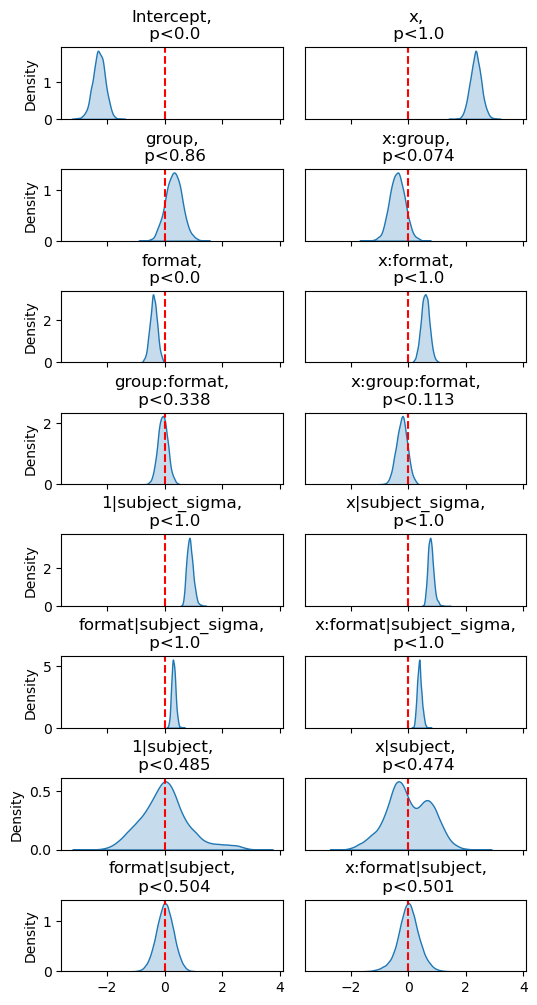

In [17]:
variable_names = list(traces.posterior.data_vars.keys())  # variable_names = list(traces.posterior.data_vars.keys()) 
n_rows = int(len(variable_names) / 2 )
fig, axs = plt.subplots(n_rows,2, figsize=(6, 12), sharex=True)

for i in range(n_rows):
    for j in range(2): # intercept & slope 
        index = i * 2 + j
        var = variable_names[index] # goes till 7/8
        temp = traces.posterior[var].to_dataframe()
        count_greater_zero = np.round(np.mean(temp[var] > 0),3)
        sns.kdeplot(temp, ax=axs[i, j],legend=False, fill=True)
        if j!= 0:
            axs[i, j].set(yticks=[],ylabel='')
        axs[i, j].axvline(x=0, color='r', linestyle='--')
        axs[i, j].set_title(f'{var},\n p<{count_greater_zero}')
        print(f'{var}: mean={temp[var].mean()}, 95%CI={np.percentile(temp[var], [2.5, 97.5])}')

fig.subplots_adjust(wspace=0.1, hspace=0.7)   

In [22]:
import scipy.stats as ss

def invprobit(x):
    return ss.norm.ppf(x)

def extract_rnp_precision(trace, model, data, format=False, group=False,risky_left=False):

    data = data.reset_index()

    reg_list = [data.reset_index()['subject'].unique(),[0, 1], data['n_safe'].unique()]
    names=['subject', 'x', 'n_safe', 'format']
    
    if format:
        reg_list.append(data['format'].unique())
        names.append('format')
    if group:
        reg_list.append(data['group'].unique())
        names.append('group')   
    if risky_left:
        reg_list.append([False, True])
        names.append('risky_left')

    fake_data = pd.MultiIndex.from_product([reg_list],names=names).to_frame().reset_index(drop=True)

    pred = model.predict(trace, 'mean', fake_data, inplace=False)['posterior']['chose_risky_mean']

    pred = pred.to_dataframe().unstack([0, 1])
    pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))

    # return pred

    pred0 = pred.xs(0, 0, 'x')
    intercept = pd.DataFrame(invprobit(pred0), index=pred0.index, columns=pred0.columns)
    gamma = invprobit(pred.xs(1, 0, 'x')) - intercept

    return intercept, gamma

In [23]:
#from utils import extract_rnp_precision

intercept, gamma = extract_rnp_precision(traces, model, df, format = True,group=True)
rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])
rnp.columns = ['rnp']

TypeError: unhashable type: 'numpy.ndarray'

/Users/mrenke/mambaforge/envs/behav_fit2_clone/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


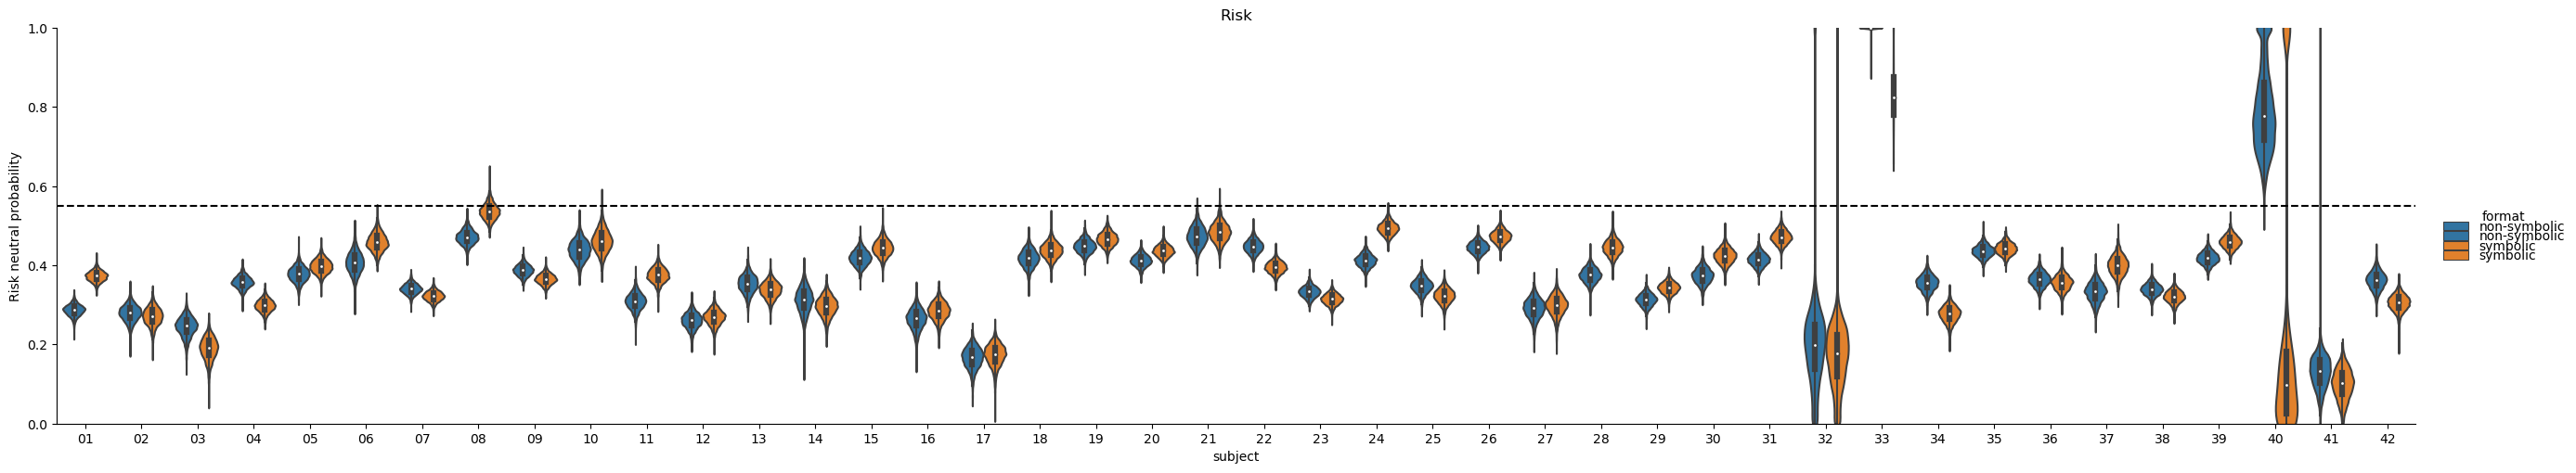

In [14]:
fac = sns.catplot(x='subject', y='rnp', data=rnp.reset_index(), hue='format', aspect=5., kind='violin')
plt.ylim(0, 1)
plt.axhline(.55, c='k', ls='--', label='risk-neutral')
fac.set(title='Risk', ylabel='Risk neutral probability')
fac.add_legend()

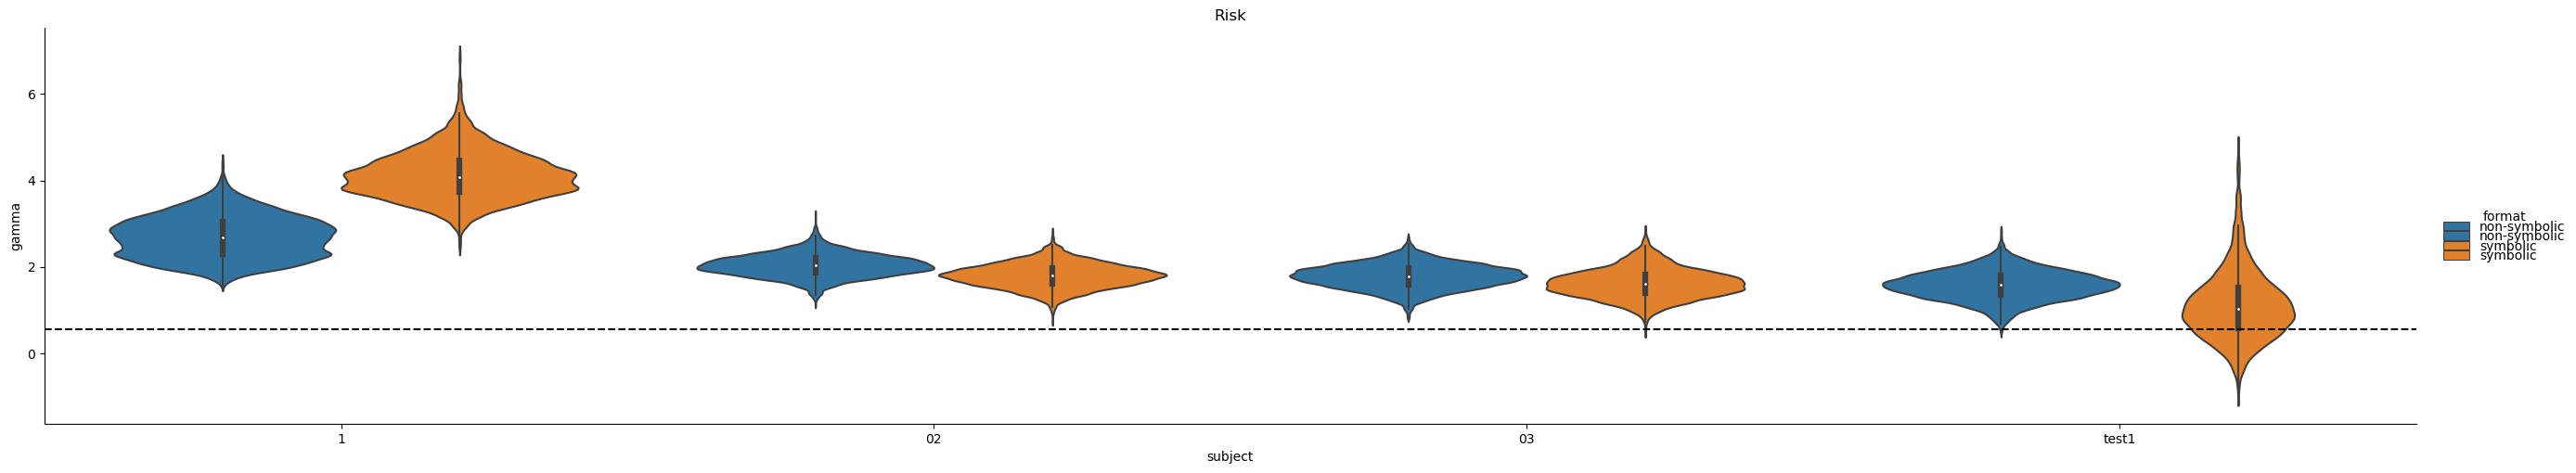

In [13]:
g = gamma.stack([1, 2])
g.columns = ['gamma']

fac = sns.catplot(x='subject', y='gamma', data=g.reset_index(), aspect=5., kind='violin', hue='format')
#plt.ylim(0, 1)
plt.axhline(.55, c='k', ls='--', label='risk-neutral')
fac.set(title='Risk', ylabel='gamma')
fac.add_legend()

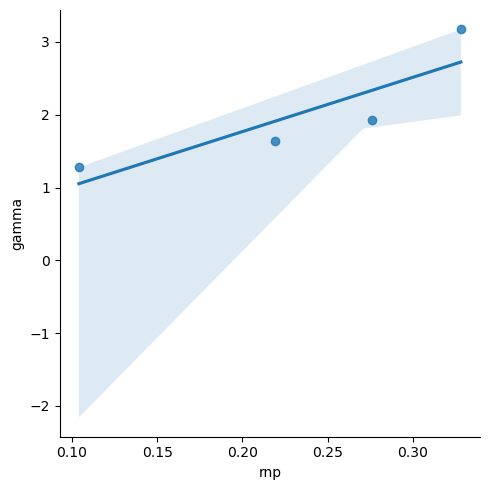

In [9]:
gamma_ = gamma.stack([1, 2]).groupby(['subject']).mean()
gamma_.columns = ['gamma']

rnp_ = rnp.groupby(['subject']).mean()

pars = rnp_.join(gamma_)
sns.lmplot(x='rnp', y='gamma', data=pars)

In [15]:
rnp.groupby(['subject', 'format']).mean()

rnp
subject format                
02      non-symbolic  0.280420
        symbolic      0.268763
03      non-symbolic  0.248684
        symbolic      0.191634
1       non-symbolic  0.276946
        symbolic      0.375925
test1   non-symbolic  0.163773
        symbolic      0.095177

In [21]:
# ppc
def format_bambi_ppc(trace, model, df):

    preds = []
    for key, kind in zip(['ll_bernoulli', 'p'], ['pps', 'mean']):
        pred = model.predict(trace, kind=kind, inplace=False) 
        if kind == 'pps':
            pred = pred['posterior_predictive']['chose_risky'].to_dataframe().unstack(['chain', 'draw'])['chose_risky']
        else:
            pred = pred['posterior']['chose_risky_mean'].to_dataframe().unstack(['chain', 'draw'])['chose_risky_mean']
        pred.index = df.index
        pred = pred.set_index(pd.MultiIndex.from_frame(df), append=True)
        preds.append(pred)

    pred = pd.concat(preds, keys=['ll_bernoulli', 'p'], names=['variable'])
    return pred

In [24]:
ppc = format_bambi_ppc(traces, model, df)

In [31]:
def summarize_ppc(ppc, groupby=None):

    if groupby is not None:
        ppc = ppc.groupby(groupby).mean()

    e = ppc.mean(1).to_frame('p_predicted')
    hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
                       columns=['hdi025', 'hdi975'])

    print(hdi)
    return pd.concat((e, hdi), axis=1)

def plot_prediction(data, x, color, y='p_predicted', alpha=.25, **kwargs):
    data = data[~data['hdi025'].isnull()]
    plt.fill_between(data[x], data['hdi025'],
                     data['hdi975'], color=color, alpha=alpha)
    plt.plot(data[x], data[y], color=color)    

In [ ]:
summarize_ppc(ppc, groupby=None)

In [32]:
def plot_ppc(df, ppc, plot_type=1, var_name='ll_bernoulli', level='subject', col_wrap=5):

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()

    df = df.copy()

    if level == 'group':
        df['log(risky/safe)'] = df['bin(risky/safe)']
        ppc = ppc.reset_index('log(risky/safe)')
        ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')

    if plot_type == 1:
        groupby = ['format', 'log(risky/safe)']
    elif plot_type in [2, 4]:
        groupby = ['format', 'n_safe']
    elif plot_type in [3, 5]:
        groupby = ['format', 'n_safe', 'log(risky/safe)']
    else:
        raise NotImplementedError

    if level == 'group':
        ppc = ppc.groupby(['subject']+groupby).mean()

    if level == 'subject':
        groupby = ['subject'] + groupby

    # print(ppc)
    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    print(ppc_summary)
    p = df.groupby(groupby).mean()[['chose_risky']]
    print(p)
    # ppc_summary = pd.concat((p, ppc_summary), axis=1).sort_index()
    ppc_summary = ppc_summary.join(p).reset_index()

    print(ppc_summary)

    if 'n_safe' in groupby:
        ppc_summary['Safe offer'] = ppc_summary['n_safe'].astype(int)

    ppc_summary['Prop. chosen risky'] = ppc_summary['chose_risky']

    if 'log(risky/safe)' in groupby:
        if level == 'group':
            ppc_summary['Predicted acceptance'] = ppc_summary['log(risky/safe)']
        else:
            ppc_summary['Log-ratio offer'] = ppc_summary['log(risky/safe)']

    if plot_type in [2, 7]:
            x = 'Safe offer'
    else:
        if level == 'group':
            x = 'Predicted acceptance'
        else:
            x = 'Log-ratio offer'

    if plot_type in [1, 2]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='format',
                            col_wrap=col_wrap if level == 'subject' else None)


    print("X", x)
    if plot_type in [1,2,3, 5]:
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'Prop. chosen risky')
        fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

    if plot_type in [1, 3, 5]:
        if level == 'subject':
            fac.map(lambda *args, **kwargs: plt.axvline(np.log(1./.55), c='k', ls='--'))
        else:
            fac.map(lambda *args, **kwargs: plt.axvline(3.5, c='k', ls='--'))
            plt.xticks([])

    
    fac.add_legend()

    return fac

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_78691/3661856131.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                                      hdi025    hdi975
subject format       log(risky/safe)                  
02      non-symbolic 0.000000            0.0  0.000000
                     0.095310            0.0  0.000000
                     0.133531            0.0  0.125000
                     0.139762            0.0  0.000000
                     0.164303            0.0  0.000000
...                                      ...       ...
test1   symbolic     1.189584            0.0  0.000000
                     1.193922            0.0  0.000000
                     1.208960            0.0  0.000000
                     1.211090            0.0  0.125000
                     1.386294            0.0  0.083333

[240 rows x 2 columns]
                                      p_predicted  hdi025    hdi975
subject format       log(risky/safe)                               
02      non-symbolic 0.000000            0.005750     0.0  0.000000
                     0.095310            0.011667     0.0

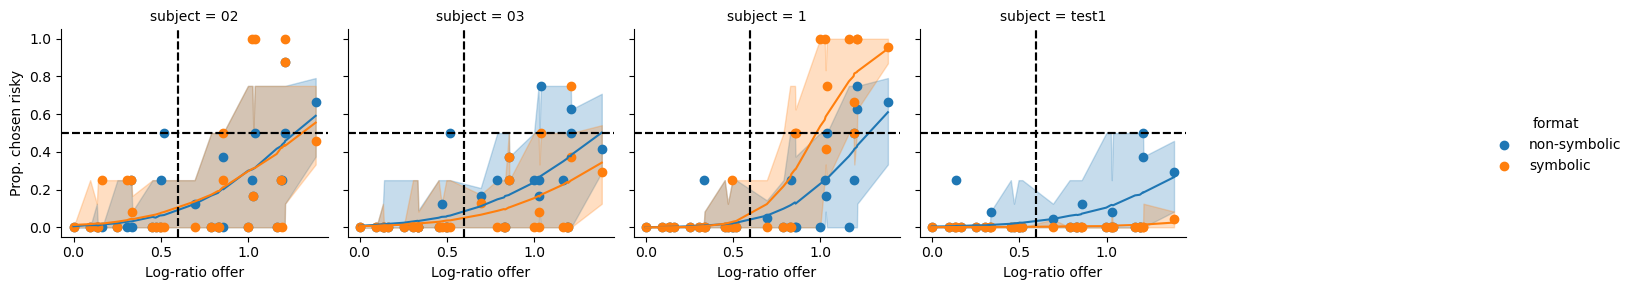

In [33]:
plot_ppc(df, ppc)

In [34]:
def cluster_offers(d, n=6, key='log(risky/safe)'):
    return pd.qcut(d[key], n, duplicates='drop').apply(lambda x: x.mid)

In [35]:
df['log(risky/safe)'] = df.groupby(['subject'], group_keys=False).apply(cluster_offers)



/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_78691/3661856131.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                                        hdi025    hdi975
subject format       log(risky/safe)                    
02      non-symbolic 0.1650           0.000000  0.057143
                     0.4160           0.000000  0.125000
                     0.6445           0.000000  0.218750
                     0.9080           0.071429  0.357143
                     1.1190           0.187500  0.531250
                     1.2980           0.375000  0.750000
        symbolic     0.1650           0.000000  0.083333
                     0.4160           0.000000  0.125000
                     0.6445           0.031250  0.250000
                     0.9080           0.071429  0.392857
                     1.1190           0.156250  0.500000
                     1.2980           0.343750  0.718750
03      non-symbolic 0.1585           0.000000  0.062500
                     0.4095           0.000000  0.114286
                     0.6445           0.000000  0.218750
                     0.9090    

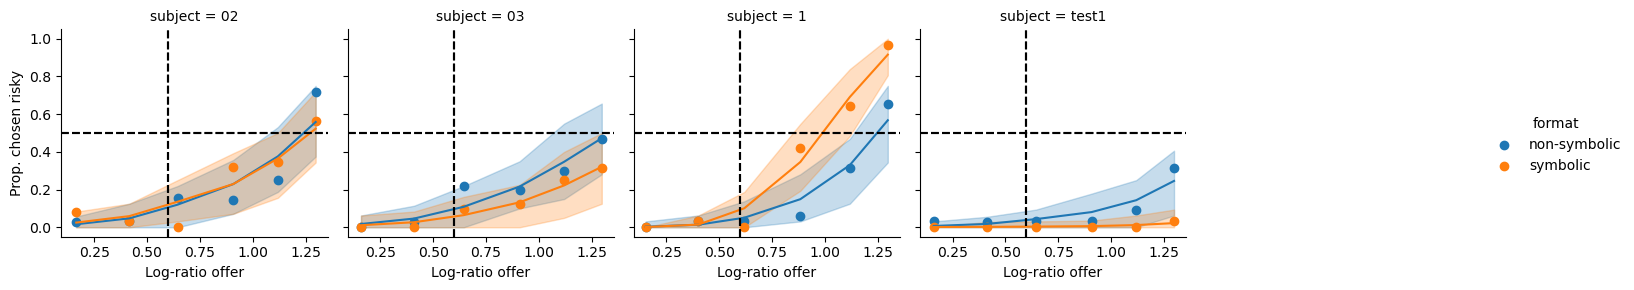

In [36]:
ppc = format_bambi_ppc(traces, model, df)
plot_ppc(df, ppc)